# OPM-MEG Tutorials in OSL: Pre-Processing

### Note: data collected at Oxford OPM Lab December 2024

### Cerca Magnetics Neuro-1, 64-sensor QZFM OPM System

<img src="20250107_12_27_06_01.jpg" style="width:30%;">

These scripts require homogenous field correction (Tierney et al., 2021) which is only available in MNE 0.18 and above. The newest version of osl-ephys has this requirement so please upgrade!

## The Four Motor Task

The participant is cued (audio) to move one of:

- Right arm
- Left arm
- Right leg
- Left leg

For 4s followed by a variable inter-stimulus interval.

In [1]:
# We start by importing the relevant packages
import osl_ephys
import numpy as np
import mne
import glob
import yaml
import os
import matplotlib.pyplot as plt

print('MNE version: {}'.format(mne.__version__))

# Set global font to Open Sans
plt.rcParams['font.family'] = 'sans-serif'
plt.rcParams['font.sans-serif'] = ['Helvetica']
plt.rcParams['font.size'] = 12  # Adjust font size as desired


Using matplotlib as 2D backend.
MNE version: 1.10.1


In [12]:
%matplotlib inline


## Specify Subject, Session and Task

In [13]:
subject = '001'
ses     = '001'
task    = 'fourMotor'

## Load in the Data

In [14]:
filename = 'BIDS/sub-{}/ses-{}/meg/sub-{}_ses-{}_task-{}_run-001_meg.fif'.format(subject,ses,subject,ses,task)
raw      = mne.io.read_raw_fif(filename, preload=True)

Opening raw data file BIDS/sub-001/ses-001/meg/sub-001_ses-001_task-fourMotor_run-001_meg.fif...
    Range : 0 ... 2198783 =      0.000 ...  1465.855 secs
Ready.
Reading 0 ... 2198783  =      0.000 ...  1465.855 secs...


## Plot Sensor Layout and Data

In [16]:
# Plot the sensors to check they are in the right orientation
fig = mne.viz.plot_alignment(raw.info,dig=True)

For automatic theme detection, "darkdetect" has to be installed! You can install it with `pip install darkdetect`
For automatic theme detection, "darkdetect" has to be installed! You can install it with `pip install darkdetect`
Getting helmet for system unknown (derived from 192 MEG channel locations)
Channel types::	mag: 192


Setting up band-pass filter from 1 - 1.1e+02 Hz

IIR filter parameters
---------------------
Butterworth bandpass zero-phase (two-pass forward and reverse) non-causal filter:
- Filter order 16 (effective, after forward-backward)
- Cutoffs at 1.00, 110.00 Hz: -6.02, -6.02 dB



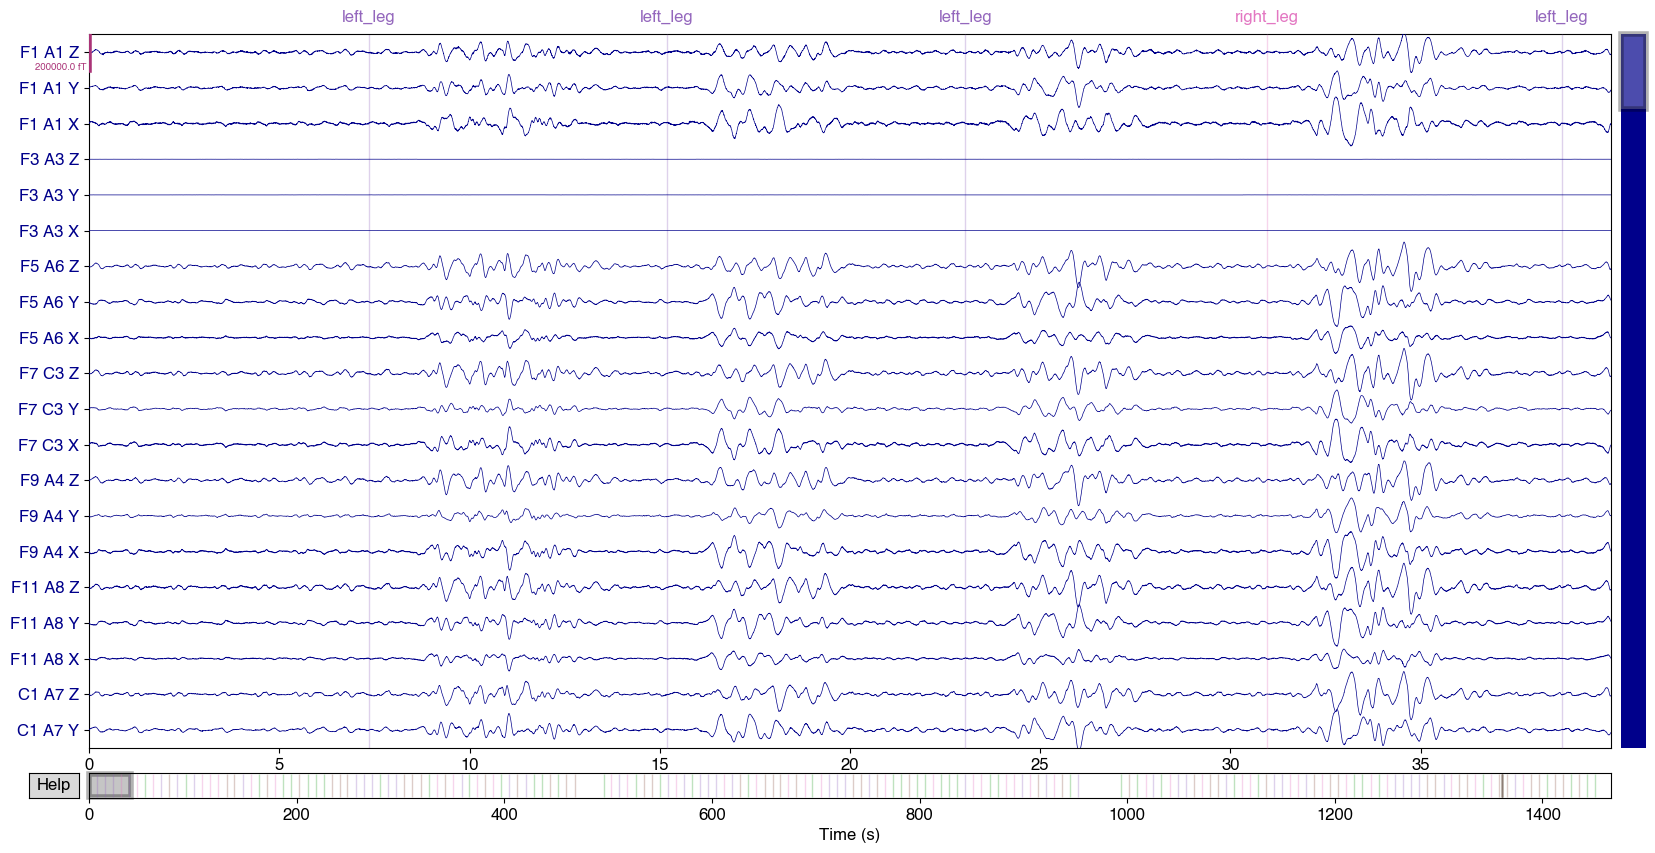

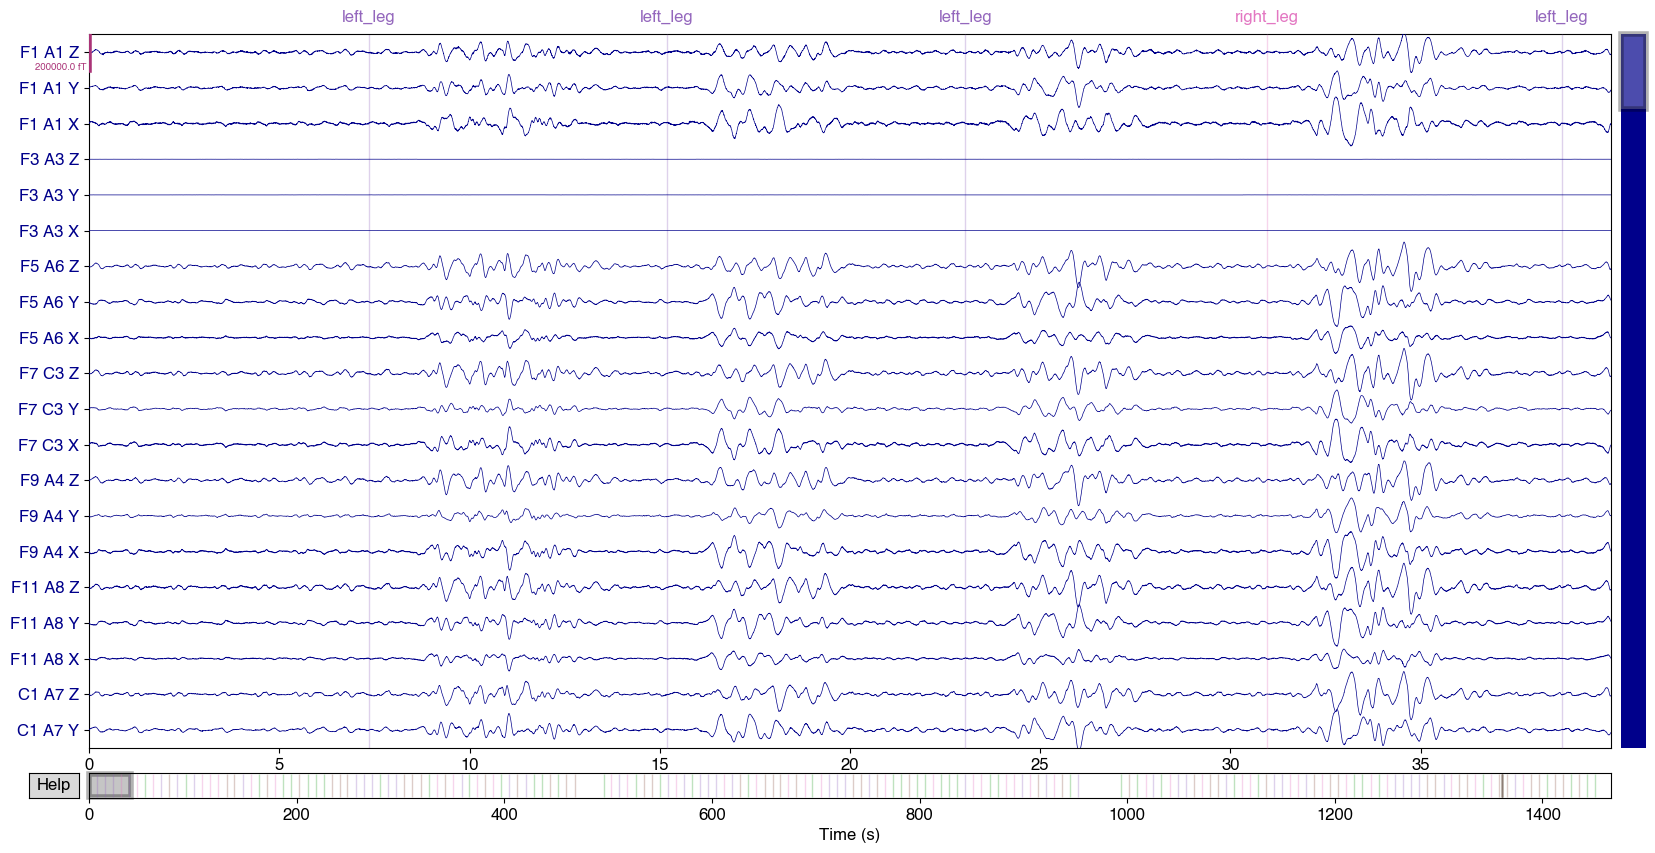

In [17]:
# Plot the first 10s of raw data
raw.plot(highpass=1,
         lowpass=110.0,scalings = {'mag' : 1e-10},
         duration=40,butterfly=False,picks='mag')

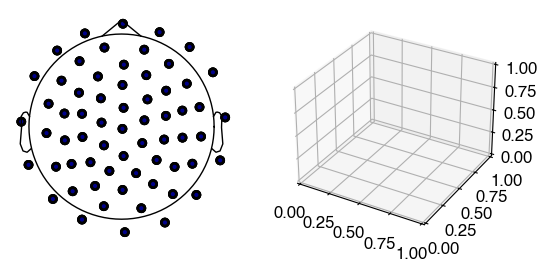

In [18]:
fig = plt.figure()
ax2d = fig.add_subplot(121)
ax3d = fig.add_subplot(122, projection="3d")
raw.plot_sensors(ch_type="mag", axes=ax2d)
raw.plot_sensors(ch_type="mag", axes=ax3d, kind="3d")
ax3d.view_init(azim=70, elev=15)

## Add in channels we know are bad - H6, A3, G8


In [19]:
# Add in channels we know are bad
import re

pattern = r'\b(H6|A3|G8) [XYZ]\b' # Modify accordingly 
matched_channels = [ch for ch in raw.info.ch_names if re.search(pattern, ch)]

raw.info['bads'].extend(matched_channels)


## Downsample the data to 300Hz

In [20]:
x = raw.copy().pick(picks=['mag'])
raw_downsampled = x.copy().resample(sfreq=300)

## Mark Bad Segments Based on Kurtosis

#### This seems to work well for the square wave jumps present in this particular dataset (now fixed)

In [21]:
from osl_ephys.preprocessing.osl_wrappers import bad_segments

raw_downsampled = bad_segments(
    raw_downsampled,
    picks='mag',
    segment_len=300,
    significance_level=0.05,
    metric='kurtosis',
    channel_wise = False
)

Setting up high-pass filter at 2 Hz

IIR filter parameters
---------------------
Butterworth highpass zero-phase (two-pass forward and reverse) non-causal filter:
- Filter order 8 (effective, after forward-backward)
- Cutoff at 2.00 Hz: -6.02 dB



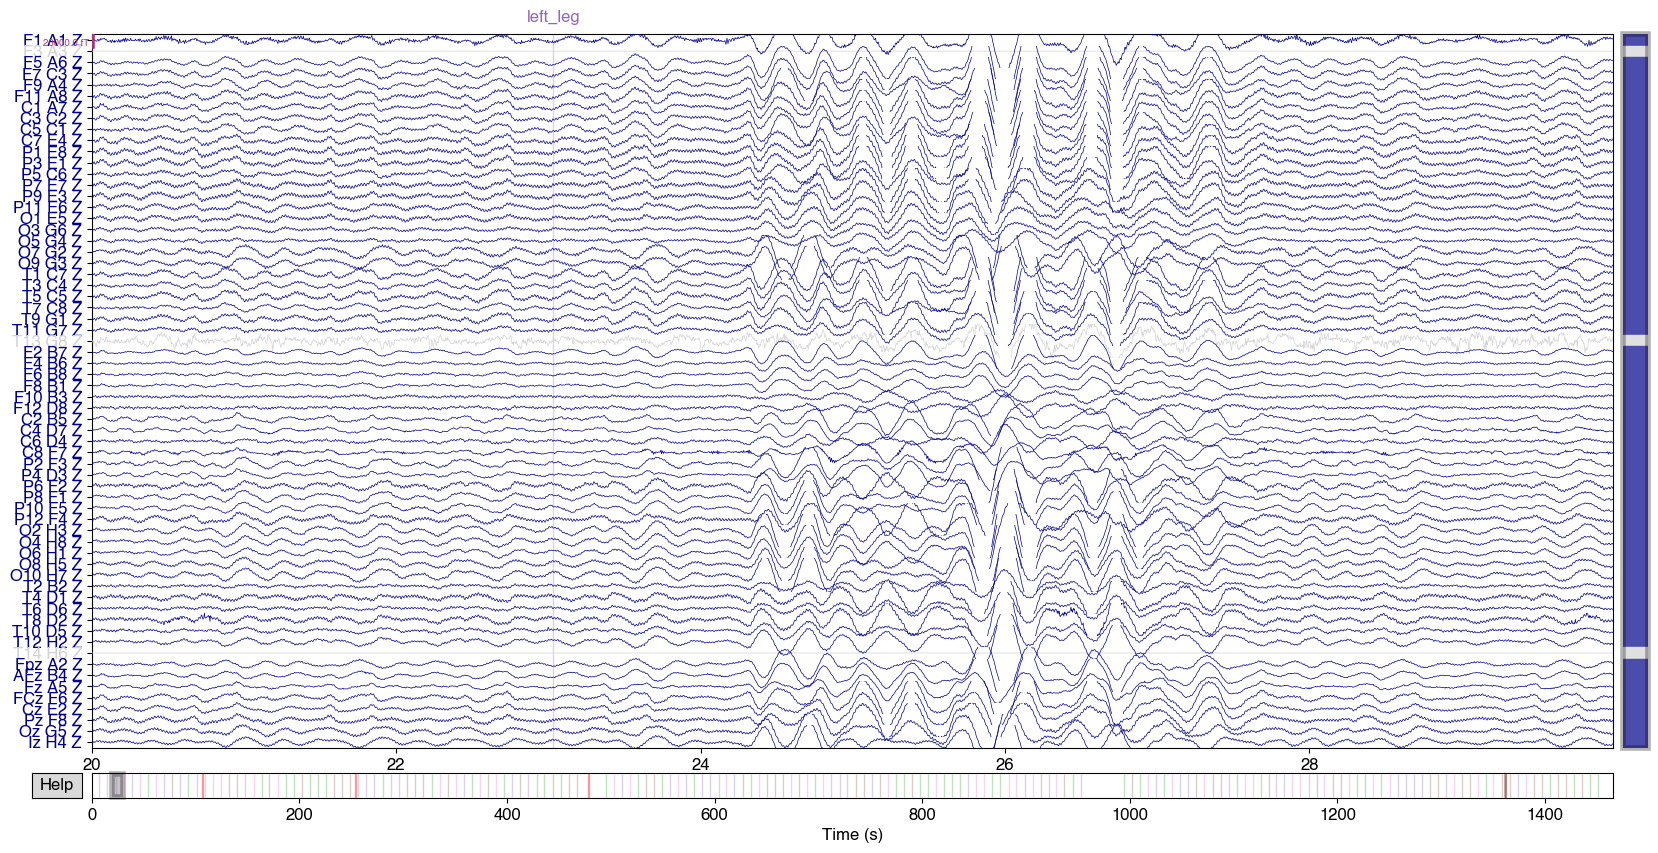

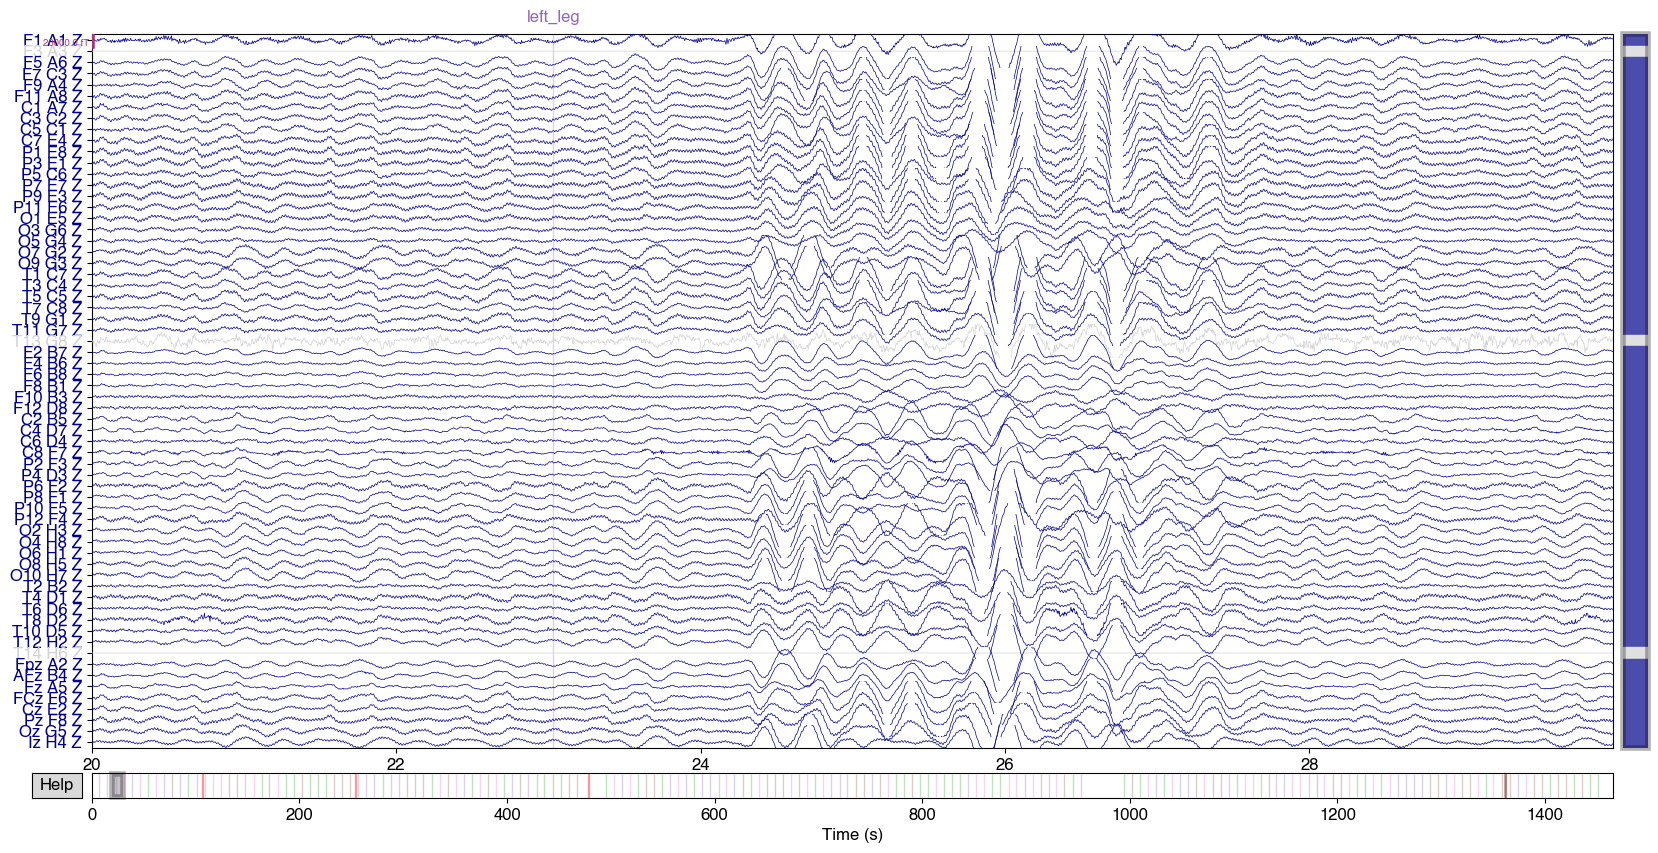

In [22]:
Z_picks = mne.pick_channels_regexp(raw_downsampled.info['ch_names'], regexp=r".*Z$")
raw_downsampled.plot(start=20,duration=10,picks=Z_picks,n_channels=64,highpass=2.0,
           butterfly=False,scalings = {'mag' : 1e-11})

## Plot the PSD

### Note we have some bad channels!

Setting 1200 of 439757 (0.27%) samples to NaN, retaining 438557 (99.73%) samples.
Effective window size : 6.667 (s)
Plotting power spectral density (dB=True).


/var/folders/lc/2w90j0s17cx3s8fl2m6h2gz80000gn/T/ipykernel_53141/4116602915.py:4: UserWarning: Infinite value in PSD for channels T14 H6 Z, T14 H6 Y.
These channels might be dead.
  fig = psd.plot()  # This now returns a figure
/opt/anaconda3/envs/osle/lib/python3.12/site-packages/mne/viz/utils.py:158: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  (fig or plt).show(**kwargs)


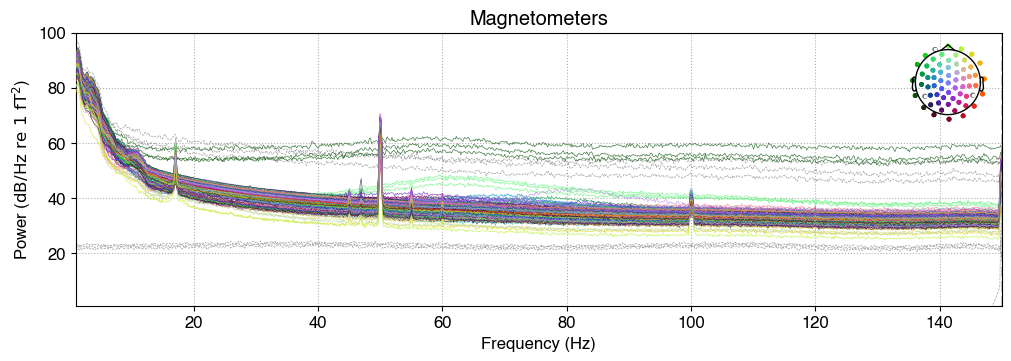

In [24]:
psd = raw_downsampled.compute_psd(fmin=1, fmax=150, n_fft=2000,reject_by_annotation=True)

# Plot the PSD
fig = psd.plot()  # This now returns a figure

# Get the axis object from the figure
ax = fig.axes[0]  # Since psd.plot() returns an array, we need to index into the first axis

# # Set the y-axis limits
ax.set_ylim(1, 100)

plt.show()

## Detect Bad Chans from PSD

#### Mark bad chans based on the PSD using an interative plot - I will soon add this to osl-ephys

In [25]:
import numpy as np
from osl_ephys.preprocessing.osl_wrappers import detect_artefacts  # type: ignore

def detect_bad_channels_psd(raw, fmin=2, fmax=80, n_fft=2000, alpha=0.05):
    """
    Detect bad channels using PSD and GESD outlier detection.

    Parameters
    ----------
    raw : mne.io.Raw
        Raw data object.
    fmin, fmax : float
        Frequency range for PSD computation.
    n_fft : int
        FFT length for PSD.
    alpha : float
        Significance level for GESD outlier detection.

    Returns
    -------
    list of str
        Detected bad channel names.
    """
    # Exclude already-marked bads
    good_chans = [ch for ch in raw.ch_names if ch not in raw.info['bads']]

    # Compute PSD (bad channels excluded by MNE)
    psd = raw.compute_psd(
        fmin=fmin, fmax=fmax, n_fft=n_fft,
        reject_by_annotation=True, verbose=False
    )
    pow_data = psd.get_data()

    if len(good_chans) != pow_data.shape[0]:
        raise RuntimeError(
            f"Channel mismatch: {len(good_chans)} chans vs PSD shape {pow_data.shape[0]}"
        )

    # Check for NaN or zero PSD
    bad_forced = [
        ch for ch, psd_ch in zip(good_chans, pow_data)
        if np.any(np.isnan(psd_ch)) or np.all(psd_ch == 0)
    ]
    if bad_forced:
        raise RuntimeError(
            f"PSD contains NaNs or all-zero values for channels: {bad_forced}"
        )

    # Log-transform PSD
    pow_log = np.log10(pow_data)

    # Detect artefacts with GESD
    mask = detect_artefacts(
        pow_log, axis=0, reject_mode="dim", gesd_args={"alpha": alpha}
    )
    return [ch for ch, is_bad in zip(good_chans, mask) if is_bad]



In [26]:
# Example usage
bad_channels = detect_bad_channels_psd(raw_downsampled, fmin=10, fmax=80, alpha=0.05)
print("Detected bad channels:", bad_channels)

Detected bad channels: ['F1 A1 Z', 'F1 A1 Y', 'T11 G7 Z', 'T11 G7 Y', 'T11 G7 X']


### Now we have removed all the bad channels

Setting 1200 of 439757 (0.27%) samples to NaN, retaining 438557 (99.73%) samples.
Effective window size : 10.000 (s)
Plotting power spectral density (dB=True).


/var/folders/lc/2w90j0s17cx3s8fl2m6h2gz80000gn/T/ipykernel_53141/128647179.py:8: UserWarning: Infinite value in PSD for channels T14 H6 Z, T14 H6 Y.
These channels might be dead.
  fig = psd.plot()  # This now returns a figure
/opt/anaconda3/envs/osle/lib/python3.12/site-packages/mne/viz/utils.py:158: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  (fig or plt).show(**kwargs)


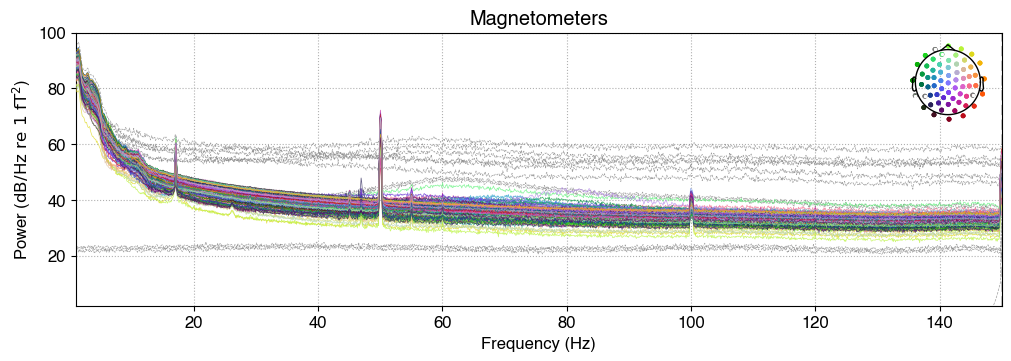

In [27]:
%matplotlib inline

# Add these channels as bad
raw_downsampled.info['bads'].extend(bad_channels)
psd = raw_downsampled.compute_psd(fmin=1, fmax=150, n_fft=3000,reject_by_annotation=True)

# Plot the PSD
fig = psd.plot()  # This now returns a figure
# Get the axis object from the figure
ax = fig.axes[0]  # Since psd.plot() returns an array, we need to index into the first axis
# # Set the y-axis limits
ax.set_ylim(2, 100)
plt.show()


## Find Events (trial onsets)

In [28]:
# Find Events From MNE Annotations

# Use plain Python strings
pattern_list = ['left_arm', 'left_leg', 'right_arm', 'right_leg']
pattern = '|'.join(pattern_list)  # For regex

# Extract events using the regex pattern
events, event_ids = mne.events_from_annotations(raw_downsampled, regexp=pattern)

# Save the events array
np.save('events.npy', events)


Used Annotations descriptions: [np.str_('left_arm'), np.str_('left_leg'), np.str_('right_arm'), np.str_('right_leg')]


## Preprocess OPM Data

### HFC - Order 1 and 2

Specify order = 1 for homogenous field or = 2 to also include gradients

3 projection items deactivated
8 projection items deactivated
Setting 1200 of 439757 (0.27%) samples to NaN, retaining 438557 (99.73%) samples.
Effective window size : 6.667 (s)
Setting 1200 of 439757 (0.27%) samples to NaN, retaining 438557 (99.73%) samples.
Effective window size : 6.667 (s)
Setting 1200 of 439757 (0.27%) samples to NaN, retaining 438557 (99.73%) samples.
Effective window size : 6.667 (s)
Plotting power spectral density (dB=True).


/var/folders/lc/2w90j0s17cx3s8fl2m6h2gz80000gn/T/ipykernel_53141/3568700118.py:34: UserWarning: Infinite value in PSD for channels T14 H6 Z, T14 H6 Y.
These channels might be dead.
  fig = psd_HFC2.plot()  # This now returns a figure
/opt/anaconda3/envs/osle/lib/python3.12/site-packages/mne/viz/utils.py:158: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  (fig or plt).show(**kwargs)


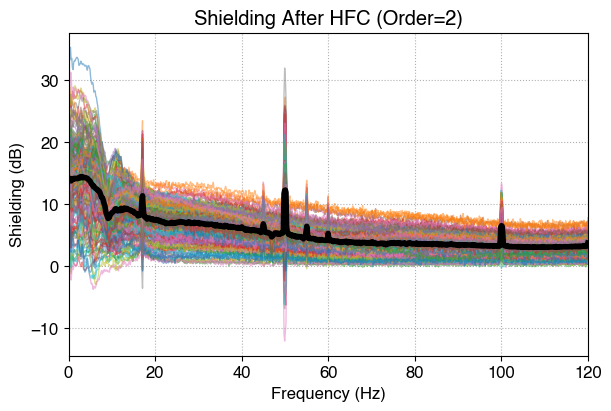

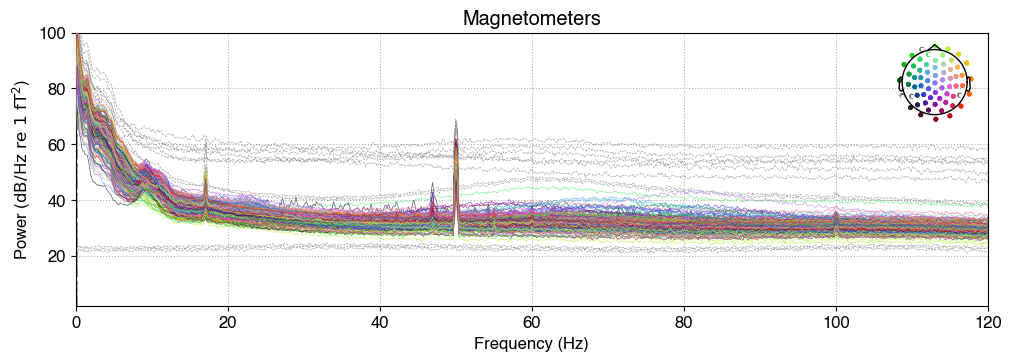

In [29]:
# Compute projections and apply them
projs1 = mne.preprocessing.compute_proj_hfc(raw_downsampled.info, order=1)
raw_hfc1 = raw_downsampled.copy().add_proj(projs1).apply_proj(verbose="error")

projs2 = mne.preprocessing.compute_proj_hfc(raw_downsampled.info, order=2)
raw_hfc2 = raw_downsampled.copy().add_proj(projs2).apply_proj(verbose="error")

# Compute PSDs
psd      = raw_downsampled.compute_psd(fmin=0, fmax=120, picks='mag', n_fft=2000)
psd_HFC1 = raw_hfc1.compute_psd(fmin=0, fmax=120, picks='mag', n_fft=2000)
psd_HFC2 = raw_hfc2.compute_psd(fmin=0, fmax=120, picks='mag', n_fft=2000)

# Extract data and freqs
psd_raw_data, freqs = psd.get_data(return_freqs=True)
psd_hfc1_data, _    = psd_HFC1.get_data(return_freqs=True)
psd_hfc2_data, _    = psd_HFC2.get_data(return_freqs=True)

# Compute shielding in dB (raw vs HFC2)
shielding = 10 * np.log10(psd_raw_data / psd_hfc2_data)

# --- Plot shielding ---
fig, ax = plt.subplots(figsize=(6, 4), layout="constrained")
ax.plot(freqs, shielding.T, lw=1, alpha=0.5)                  # all channels
ax.plot(freqs, shielding.mean(axis=0), lw=4, alpha=1, color='black')  # mean
ax.grid(True, ls=":")
ax.set(
    xlim=(0, 120),
    title="Shielding After HFC (Order=2)",
    xlabel="Frequency (Hz)",
    ylabel="Shielding (dB)",
)

# --- Plot PSD after HFC (Order=2) ---
fig = psd_HFC2.plot()  # This now returns a figure
ax = fig.axes[0]  # Since psd.plot() returns an array, we need to index into the first axis
ax.set_ylim(2, 100)
plt.show()



### Band-Pass (2-50 Hz) and Notch (50, 100 Hz) Filter

In [30]:
# BP Filter
raw_bp = raw_hfc2.copy().filter(
    l_freq=2,
    h_freq=50,
    method='iir',                # use IIR (Butterworth)
    iir_params=dict(ftype='butter', order=4),  # 4th-order Butterworth
    verbose=True
)

# Notch Filter
freqs = (50, 100)
raw_notch = raw_bp.copy().notch_filter(freqs=freqs, picks='mag',notch_widths=2)

Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 2 - 50 Hz

IIR filter parameters
---------------------
Butterworth bandpass zero-phase (two-pass forward and reverse) non-causal filter:
- Filter order 16 (effective, after forward-backward)
- Cutoffs at 2.00, 50.00 Hz: -6.02, -6.02 dB

Filtering raw data in 1 contiguous segment
Setting up band-stop filter

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandstop filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower transition bandwidth: 0.50 Hz
- Upper transition bandwidth: 0.50 Hz
- Filter length: 1981 samples (6.603 s)



## Save the Intermediate Data

In [31]:
# Define the directory path where you want to save the file
output_dir = 'BIDS/derivatives/preprocessing/sub-{}/ses-{}/meg'.format(subject,ses)
output_file = 'sub-{}_ses-{}_task-{}_run-001_preICA.fif'.format(subject,ses,task)

# Create the directory if it doesn't exist
os.makedirs(output_dir, exist_ok=True)

# # Save the clean data
raw_notch.save(os.path.join(output_dir, output_file),overwrite=True)

Overwriting existing file.
Writing /Users/robertseymour/data/study-OPM_training/BIDS/derivatives/preprocessing/sub-001/ses-001/meg/sub-001_ses-001_task-fourMotor_run-001_preICA.fif
Overwriting existing file.


/var/folders/lc/2w90j0s17cx3s8fl2m6h2gz80000gn/T/ipykernel_53141/3755338357.py:9: RuntimeWarning: This filename (/Users/robertseymour/data/study-OPM_training/BIDS/derivatives/preprocessing/sub-001/ses-001/meg/sub-001_ses-001_task-fourMotor_run-001_preICA.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or _ieeg.fif.gz
  raw_notch.save(os.path.join(output_dir, output_file),overwrite=True)


Closing /Users/robertseymour/data/study-OPM_training/BIDS/derivatives/preprocessing/sub-001/ses-001/meg/sub-001_ses-001_task-fourMotor_run-001_preICA.fif
[done]


[PosixPath('/Users/robertseymour/data/study-OPM_training/BIDS/derivatives/preprocessing/sub-001/ses-001/meg/sub-001_ses-001_task-fourMotor_run-001_preICA.fif')]

## ICA

In [32]:
from mne.preprocessing import ICA
from mne.viz import plot_topomap
import numpy as np

# Compute ICA on all channels (use raw_notch as input)
ica = ICA(n_components=60, random_state=34, max_iter=800,method='fastica')
ica.fit(raw_notch)  # Fit ICA on all channels


Fitting ICA to data using 178 channels (please be patient, this may take a while)
Omitting 1200 of 439757 (0.27%) samples, retaining 438557 (99.73%) samples.
    Applying projection operator with 8 vectors (pre-whitener computation)
    Applying projection operator with 8 vectors (pre-whitener application)
Selecting by number: 60 components
    Applying projection operator with 8 vectors (pre-whitener application)
Fitting ICA took 17.2s.


<ICA | raw data decomposition, method: fastica (fit in 57 iterations on 438557 samples), 60 ICA components (178 PCA components available), channel types: mag, no sources marked for exclusion>

### Plot ICA sources - the default osl-ephys plotter cannot only plot the Z-orientation

In [38]:
%matplotlib qt

browser = ica.plot_sources(raw_notch, show_scrollbars=False)
browser.show()  # Show it if not already visible

# Access the underlying Qt window and resize
qt_window = browser.canvas.parent()
qt_window.resize(1200, 600)

from mne.viz import plot_topomap
import math

def plot_ica_topomaps_Z(raw_notch, ica, batch_size=10, colormap='RdBu_r'):
    """
    Plot ICA components as topomaps for selected good Z channels, displaying them in batches.
    """

    # Get good channels
    all_channels = raw_notch.info['ch_names']
    bad_channels = raw_notch.info['bads']
    good_channels = [ch for ch in all_channels if ch not in bad_channels]

    # Get channels matching the regex pattern
    Z_picks = mne.pick_channels_regexp(all_channels, regexp=r".*Z$")
    Z_channels = [all_channels[i] for i in Z_picks]

    # Keep only good Z channels
    Z_good_channels = [ch for ch in Z_channels if ch in good_channels]

    # Get ICA channel names
    ica_channels = ica.info['ch_names']

    # Indices of Z good channels in ICA
    Z_good_ica_picks = [ica_channels.index(ch) for ch in Z_good_channels]

    # Use only info (no data copy) for plotting
    raw_info_Z = raw_notch.copy().pick_channels(Z_good_channels).info

    # Get ICA components
    ica_data = ica.get_components()
    num_components = ica.n_components_

    # Suppress interactive rendering
    plt.ioff()

    # Loop through components in batches
    for i in range(0, num_components, batch_size):
        num_subplots = min(batch_size, num_components - i)
        rows = int(math.ceil(num_subplots / 6))  # 6 columns
        cols = 6

        fig, axes = plt.subplots(rows, cols, figsize=(7, 12))
        axes = axes.ravel()

        for idx, comp in enumerate(range(i, min(i + batch_size, num_components))):
            comp_data = ica_data[Z_good_ica_picks, comp]
            ax = axes[idx]

            plot_topomap(comp_data, raw_info_Z, axes=ax, show=False,
                         size=3, cmap=colormap)

            ax.text(-0.2, 0.5, f'{comp}', transform=ax.transAxes,
                    fontsize=6, va='center', ha='right')

        # Hide unused axes
        for j in range(idx + 1, len(axes)):
            axes[j].axis('off')

        plt.tight_layout()

    # Render all figures at once
    plt.show()
    plt.ion()

plot_ica_topomaps_Z(raw_notch, ica, batch_size=60, colormap='Spectral_r')



    Applying projection operator with 8 vectors (pre-whitener application)
Creating RawArray with float64 data, n_channels=60, n_times=439757
    Range : 0 ... 439756 =      0.000 ...  1465.853 secs
Ready.
NOTE: pick_channels() is a legacy function. New code should use inst.pick(...).


### Manually specify the components to exclude

In [34]:
ica.exclude = [40,59]  # indices chosen based on various plots above

In [35]:
# # Remove bad components from the data
clean = ica.apply(raw_notch.copy())

Applying ICA to Raw instance
    Applying projection operator with 8 vectors (pre-whitener application)
    Transforming to ICA space (60 components)
    Zeroing out 2 ICA components
    Projecting back using 178 PCA components


### Plot again

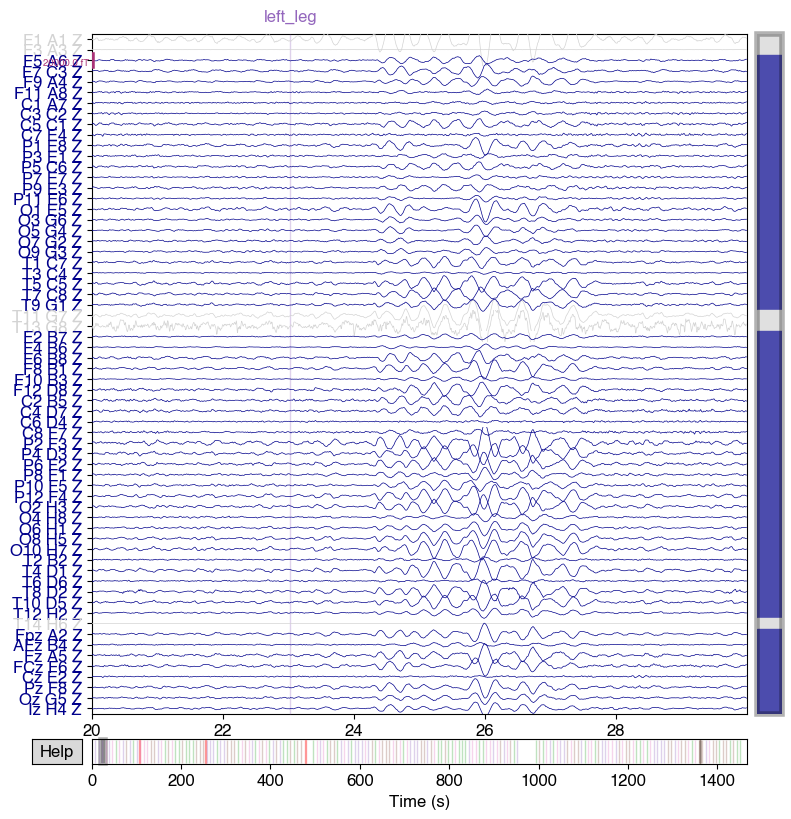

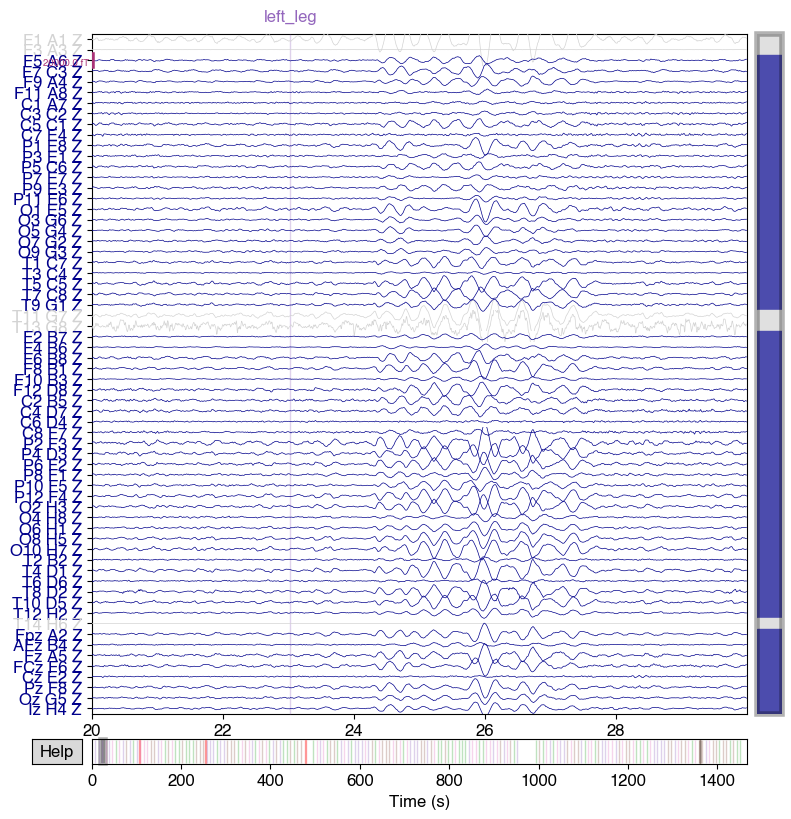

In [40]:
%matplotlib inline
Z_picks = mne.pick_channels_regexp(clean.info['ch_names'], regexp=r".*Z$")
clean.plot(start=20,duration=10,picks=Z_picks,n_channels=64,
           butterfly=False,scalings = {'mag' : 1e-11})
# plt.savefig('clean_plot.png', dpi=300, bbox_inches='tight')

## Save the Clean Data

In [41]:
# Define the directory path where you want to save the file
output_dir = 'BIDS/derivatives/preprocessing/sub-{}/ses-{}/meg'.format(subject,ses)
output_file = 'sub-{}_ses-{}_task-{}_run-001_clean.fif'.format(subject,ses,task)

# Create the directory if it doesn't exist
os.makedirs(output_dir, exist_ok=True)

# # Save the clean data
clean.save(os.path.join(output_dir, output_file),overwrite=True)


Overwriting existing file.
Writing /Users/robertseymour/data/study-OPM_training/BIDS/derivatives/preprocessing/sub-001/ses-001/meg/sub-001_ses-001_task-fourMotor_run-001_clean.fif
Overwriting existing file.


/var/folders/lc/2w90j0s17cx3s8fl2m6h2gz80000gn/T/ipykernel_53141/2785310491.py:9: RuntimeWarning: This filename (/Users/robertseymour/data/study-OPM_training/BIDS/derivatives/preprocessing/sub-001/ses-001/meg/sub-001_ses-001_task-fourMotor_run-001_clean.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or _ieeg.fif.gz
  clean.save(os.path.join(output_dir, output_file),overwrite=True)


Closing /Users/robertseymour/data/study-OPM_training/BIDS/derivatives/preprocessing/sub-001/ses-001/meg/sub-001_ses-001_task-fourMotor_run-001_clean.fif
[done]


[PosixPath('/Users/robertseymour/data/study-OPM_training/BIDS/derivatives/preprocessing/sub-001/ses-001/meg/sub-001_ses-001_task-fourMotor_run-001_clean.fif')]